In [93]:
import pandas as pd

In [94]:
# Load Dataset
test_df = pd.read_csv('DATA/v2/test.csv')
test_df['status'] = test_df['status'].apply(lambda x : str(x).strip())

In [95]:
test_df.head()

,instansi,status,reference
0,kementerian agraria dan tata ruang/badan perta...,yes,kementerian agraria
1,kementerian agraria dan tata ruang/badan perta...,yes,kementerian tata ruang
2,kementerian agraria dan tata ruang/badan perta...,yes,kementerian badan pertanahan nasional
3,kementerian agraria dan tata ruang/badan perta...,yes,badan pertanahan nasional
4,kementerian agraria dan tata ruang/badan perta...,yes,atr


In [96]:
test_df = test_df[['instansi','reference','status']]

In [97]:
test_df.head()

,instansi,reference,status
0,kementerian agraria dan tata ruang/badan perta...,kementerian agraria,yes
1,kementerian agraria dan tata ruang/badan perta...,kementerian tata ruang,yes
2,kementerian agraria dan tata ruang/badan perta...,kementerian badan pertanahan nasional,yes
3,kementerian agraria dan tata ruang/badan perta...,badan pertanahan nasional,yes
4,kementerian agraria dan tata ruang/badan perta...,atr,yes


In [98]:
list_model = ['indobert-base-p1', 'indobert-base-p2']
INDEX = 1

In [99]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('indobenchmark/{}'.format(list_model[INDEX]))
labels = {'no':0,
          'yes':1,
          }


In [100]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['status']]
        self.texts = [tokenizer(df['instansi'][i], df['reference'][i],
                               padding='max_length', max_length = 512, truncation=True, 
                               return_tensors="pt") for i in range(0,len(df.index))]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [101]:
from torch import nn
from transformers import BertModel

In [102]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('indobenchmark{}'.format(list_model[INDEX]))
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [103]:
model = torch.load('Models/{}'.format(list_model[INDEX]))

In [104]:
import torch.nn.functional as F

In [105]:
# import pandas as pd
# from indexing import search, preprocess_reference_data, index

# def create_reference_data(version):
#     prd = preprocess_reference_data.PreprocessReferenceData()
    
#     train = pd.read_csv(f'indexing/data/splitted_data/{version}/train.csv')
#     val = pd.read_csv(f'indexing/data/splitted_data/{version}/val.csv')
#     test = pd.read_csv(f'indexing/data/splitted_data/{version}/test.csv')
#     labeled_df = pd.concat([train,val,test])

#     bumn_df = pd.read_csv('indexing/data/from_kpk/Daftar BUMN AI.csv')
#     klpd_df = pd.read_csv('indexing/data/from_kpk/Daftar KLPD PPG AI.csv')

#     reference_data = prd.combine_reference_data(labeled_df, bumn_df, klpd_df)
#     reference_data.to_csv(f'indexing/data/indexing/{version}/reference_data.csv')
#     return reference_data

# def create_index_table(version, reference_data):
#     idx = index.Index(reference_data)

#     index_table = idx.get_index_table()
#     index_table.to_csv(f'indexing/data/indexing/{version}/index_table.csv')

#     return index_table

# def search_synonim (instansi) :     
#     reference_data = pd.read_csv('indexing/data/indexing/v2/reference_data.csv')

#     index_table = create_index_table('v2', reference_data)
#     print(index_table)

#     index_table = pd.read_csv('indexing/data/indexing/v2/index_table.csv')

#     Test search
#     s = search.Search(reference_data, index_table)

#     nama_instansi = instansi
#     phrase_candidates = s.search(nama_instansi)
#     list_candidates = list(phrase_candidates.values())
#     list_candidates= [x for y in list_candidates for x in y]


#     return(list_candidates)

# table_ai = pd.read_csv('DATA\\v2\distinct_instansi_ai_table.csv')

# sinonim_index = []
# instansi_index = []
# for idx in table_ai.index :
##     append sinonim element
#     temp = search_synonim(str(table_ai['nama_instansi'][idx]))
#     instansi_index.append(temp)
##     append instansi element
#     temp_sinonim = [str(table_ai['nama_instansi'][idx])]
#     temp_sinonim = temp_sinonim*len(temp)
#     for temp_sin in temp_sinonim :
#         sinonim_index.append(temp_sin)

# instansi_index = [x for y in instansi_index for x in y]
# test_df_indexing = pd.DataFrame({"instansi" : instansi_index, "sinonim" : sinonim_index})
# test_df_indexing.to_csv("DATA\\v2\kandidat_table_ai.csv")




# #Predict
# def evaluate_with_indexing(model, test_data):

#     test = Dataset(test_data)

#     test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

#     use_cuda = torch.cuda.is_available()
#     device = torch.device("cuda" if use_cuda else "cpu")

#     if use_cuda:

#         model = model.cuda()

#     total_acc_test = 0
#     probs = []
#     preds = []

#     with torch.no_grad():

#         for test_input, test_label in test_dataloader:

#               test_label = test_label.to(device)
#               mask = test_input['attention_mask'].to(device)
#               input_id = test_input['input_ids'].squeeze(1).to(device)

#               output = model(input_id, mask)
#               prob = F.softmax(output, dim=1)
#               pred = output.argmax(dim=1)
#               probs.append(prob)
#               preds.append(pred)

#               #pred_class
#               temp_pred = []
#               for i in range(0,len(preds)):
#                 a = preds[i].cpu().numpy().tolist()
#                 temp_pred.append(a)
#               list_pred = [x for y in temp_pred for x in y]
              
#               #prob values
#               temp_prob = []
#               for i in range(0,len(probs)):
#                 a = probs[i].cpu().numpy().tolist()
#                 temp_prob.append(a)
#               list_prob = [max(x) for y in temp_prob for x in y]


#               acc = (output.argmax(dim=1) == test_label).sum().item()
#               total_acc_test += acc
    
#     print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
#     new_test_data = test_data.copy()
#     new_test_data['pred'] = list_pred
#     new_test_data['prob'] = list_prob

#     new_test_data = new_test_data[['instansi', 'sinonim', 'pred', 'prob']]

#     return new_test_data
    
# test_df = pd.read_csv('DATA/v2/test.csv')   
# pred_result = evaluate_with_indexing(model, test_df)
# pred_result.to_csv('result/indexing/hasil_prediksi_{}.csv'.format(list_model[INDEX]))

In [106]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    probs = []
    preds = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              prob = F.softmax(output, dim=1)
              pred = output.argmax(dim=1)
              probs.append(prob)
              preds.append(pred)

              #pred_class
              temp_pred = []
              for i in range(0,len(preds)):
                a = preds[i].cpu().numpy().tolist()
                temp_pred.append(a)
              list_pred = [x for y in temp_pred for x in y]
              
              #prob values
              temp_prob = []
              for i in range(0,len(probs)):
                a = probs[i].cpu().numpy().tolist()
                temp_prob.append(a)
              list_prob = [max(x) for y in temp_prob for x in y]


              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    new_test_data = test_data.copy()
    new_test_data['pred'] = list_pred
    new_test_data['prob'] = list_prob

    new_test_data = new_test_data[['instansi', 'reference', 'status', 'pred', 'prob']]

    return new_test_data
    
test_df = pd.read_csv('DATA/v2/test.csv')   
pred_result = evaluate(model, test_df)
pred_result.to_csv('result/hasil_prediksi_{}.csv'.format(list_model[INDEX]))

Test Accuracy:  0.912


In [107]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [108]:
pred_result['status'] = pred_result['status'].map({"yes" : 1, "no" : 0})

In [109]:
label_true = pred_result['status'].values
prediction = pred_result['pred'].values

cf_matrix = confusion_matrix(label_true, prediction)

<AxesSubplot:>

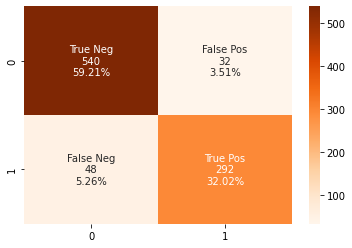

In [110]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges')

In [113]:
pred_result.head()

,instansi,reference,status,pred,prob
0,kementerian agraria dan tata ruang/badan perta...,kementerian agraria,1,0,0.915881
1,kementerian agraria dan tata ruang/badan perta...,kementerian tata ruang,1,1,0.610733
2,kementerian agraria dan tata ruang/badan perta...,kementerian badan pertanahan nasional,1,1,0.996986
3,kementerian agraria dan tata ruang/badan perta...,badan pertanahan nasional,1,1,0.997938
4,kementerian agraria dan tata ruang/badan perta...,atr,1,1,0.686853


In [124]:
pred_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   instansi   912 non-null    object 
 1   reference  912 non-null    object 
 2   status     912 non-null    int64  
 3   pred       912 non-null    int64  
 4   prob       912 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 35.8+ KB


In [125]:
dup_df = pred_result[pred_result['reference'].duplicated(keep=False)]
unique_ref = dup_df.sort_values(by='reference')['reference'].unique().tolist()

idx_to_drop = []
counter = 0
for u_ref in unique_ref :
    d = dup_df[dup_df['reference']==u_ref]
    if 1 in d['pred'].values.tolist():
        d_new = d[d['status']==1].loc[d['pred']==1]
        idx_temp = d_new[d_new['prob']==d_new['prob'].max()].index.tolist()
        if len(idx_temp) > 1 :
            idx_temp = idx_temp[0]
        idx_drop = d.drop(idx_temp, axis=0).index.tolist()
        for idx  in idx_drop : 
            idx_to_drop.append(idx)
    elif 1 not in d['pred'].values.tolist():
        d_new = d[d['status']==0].loc[d['pred']==0]
        idx_temp = d_new[d_new['prob']==d_new['prob'].max()].index.tolist()
        if len(idx_temp) > 1 :
            idx_temp = idx_temp[0]
        idx_drop = d.drop(idx_temp, axis=0).index.tolist()
        for idx in idx_drop : 
            idx_to_drop.append(idx)
    else :
        idx_temp = d['prob'].index.tolist()
        for idx  in idx_temp : 
            idx_to_drop.append(idx)


new_result_df = pred_result.drop(idx_to_drop, axis=0)
new_result_df = new_result_df[['instansi', 'reference', 'status', 'pred', 'prob']]
# new_result_df['status'] = new_result_df['status'].map({"yes" : 1, "no":0})
label_true = new_result_df['status'].values
prediction = new_result_df['pred'].values


new_result_df.to_csv("result/new_hasil_prediksi_{}.csv".format(list_model[INDEX]))
print("edit accuracy : {:.3f}".format(accuracy_score(prediction, label_true)))

edit accuracy : 0.905


In [126]:
new_result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 0 to 911
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   instansi   755 non-null    object 
 1   reference  755 non-null    object 
 2   status     755 non-null    int64  
 3   pred       755 non-null    int64  
 4   prob       755 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 35.4+ KB


In [ ]:
new_result_df.duplicated().sum()

0

In [1]:
import pandas as pd

In [4]:
table_ai = pd.read_csv('DATA\\v2\kandidat_table_ai.csv')

In [5]:
table_ai

,Unnamed: 0,instansi,sinonim
0,0,kementerian lingkungan hidup,Kementerian Kominfo
1,1,kementerian kehutanan,Kementerian Kominfo
2,2,kementerian kelautan,Kementerian Kominfo
3,3,kementerian kkp,Kementerian Kominfo
4,4,kementerian pembangunan manusia,Kementerian Kominfo
...,...,...,...
422688,422688,bni divisi solusi ritel,Direktur Utama PT BNI
422689,422689,bni divisi pengelolaan jaringan,Direktur Utama PT BNI
422690,422690,bni cabang jakarta kramat,Direktur Utama PT BNI
422691,422691,bank bni kantor cabang karawang,Direktur Utama PT BNI


In [6]:
table_ai = table_ai.drop("Unnamed: 0", axis=1)

In [7]:
table_ai

,instansi,sinonim
0,kementerian lingkungan hidup,Kementerian Kominfo
1,kementerian kehutanan,Kementerian Kominfo
2,kementerian kelautan,Kementerian Kominfo
3,kementerian kkp,Kementerian Kominfo
4,kementerian pembangunan manusia,Kementerian Kominfo
...,...,...
422688,bni divisi solusi ritel,Direktur Utama PT BNI
422689,bni divisi pengelolaan jaringan,Direktur Utama PT BNI
422690,bni cabang jakarta kramat,Direktur Utama PT BNI
422691,bank bni kantor cabang karawang,Direktur Utama PT BNI


In [8]:
table_ai = table_ai.assign(status="yes")

In [10]:
table_ai.iloc[400:500] = "no"

In [13]:
table_ai.to_csv('DATA\\v2\kandidat_table_ai.csv', index=False)

In [6]:
import pandas as pd

In [8]:
test_df = pd.read_csv('DATA/v2/kandidat_table_ai.csv')

In [9]:
test_df = test_df.iloc[1000:2000,:]

In [10]:
test_df.head()

,instansi,sinonim,status
1000,pt bina karya indonesia,PT Sawit Sumbermas Sarana Tbk,yes
1001,pt dirgantara indonesia,PT Sawit Sumbermas Sarana Tbk,yes
1002,pt di,PT Sawit Sumbermas Sarana Tbk,yes
1003,pt garam,PT Sawit Sumbermas Sarana Tbk,yes
1004,pt hotel indonesia natour,PT Sawit Sumbermas Sarana Tbk,yes
